In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import Workbook
from openpyxl.styles import Alignment
from openpyxl.utils import get_column_letter

datasets = ["ALL", "BTU", "HEC", "HFF", "SPS", "SSH"]
base_models = ["DecisionTree", "AdaBoost", "RandomForest", "HistGradientBoosting"]
metrics = ["accuracy", "balanced_accuracy", "f1_score", "precision", "recall", "stdev"]

model_abbrev = {
    "HistGradientBoosting": "HGB",
    "RandomForest": "RF",
    "AdaBoost": "Ada",
    "DecisionTree": "DTree"
}

method_groups = {
    "Oversampling": ["SMOTE", "SVMSMOTE", "OverSampler", "BorderlineSmote"],
    "Undersampling": ["UnderSampler", "ClusterCentroids", "OneSidedSelection"],
    "Hybrid": ["SMOTEENN", "SMOTETomek"]
}

df = pd.concat([
    pd.read_csv(path, sep=";").assign(source=name)
    for name, path in {"FULL": "wyniki.csv", "SEL": "wyniki_sel_features.csv"}.items()
], ignore_index=True).replace(-1, pd.NA)


In [67]:
def shorten_model_name(model):
    for full, short in model_abbrev.items():
        if model.startswith(full):
            return model.replace(full, short)
    return model

def detect_category(model_name):
    name = model_name.lower()
    for category, methods in method_groups.items():
        if any(m.lower() in name for m in methods):
            return category
    
    has_over = any(m.lower() in name for m in method_groups["Oversampling"])
    has_under = any(m.lower() in name for m in method_groups["Undersampling"])
    
    if has_over and has_under:
        return "Over+Under"
    return "Oversampling" if has_over else "Undersampling" if has_under else "Czysty"

def base_model(model_name):
    return model_name.split("_")[0]

def create_plots(metric, group_by, subplot_layout, subplot_size, title_prefix):
    fig, axes = plt.subplots(*subplot_layout, figsize=subplot_size)
    axes = axes.flatten()
    
    for i, group in enumerate(group_by):
        ax = axes[i]
        
        if group_by == base_models:
            data = df[df["model"].str.startswith(group)].copy()
            metric_cols = [f"{ds}_{metric}" for ds in datasets]
            data["metric_mean"] = data[metric_cols].mean(axis=1)
            plot_data = data.dropna(subset=["metric_mean"]).groupby(["source", "model"], as_index=False)["metric_mean"].mean()
        else:
            col = f"{group}_{metric}"
            data = df[df[col].notna()].copy()
            data["model"] = data["model"].apply(shorten_model_name)
            
            top_models = data.groupby("model")[col].mean().sort_values(ascending=False).head(10).index
            plot_data = data[data["model"].isin(top_models)].copy()
            plot_data.rename(columns={col: "metric_mean"}, inplace=True)
        
        plot_data["model"] = plot_data["model"].apply(shorten_model_name)
        order = plot_data.groupby("model")["metric_mean"].mean().sort_values(ascending=False).index
        
        sns.barplot(data=plot_data, x="metric_mean", y="model", hue="source", ax=ax, order=order)
        ax.set_title(f"{title_prefix}{group}: porównanie ({metric})")
        ax.legend(loc="upper left")
        ax.set_xlabel(metric if group_by == base_models else group)
        ax.set_ylabel("")
    
    plt.tight_layout()
    plt.show()

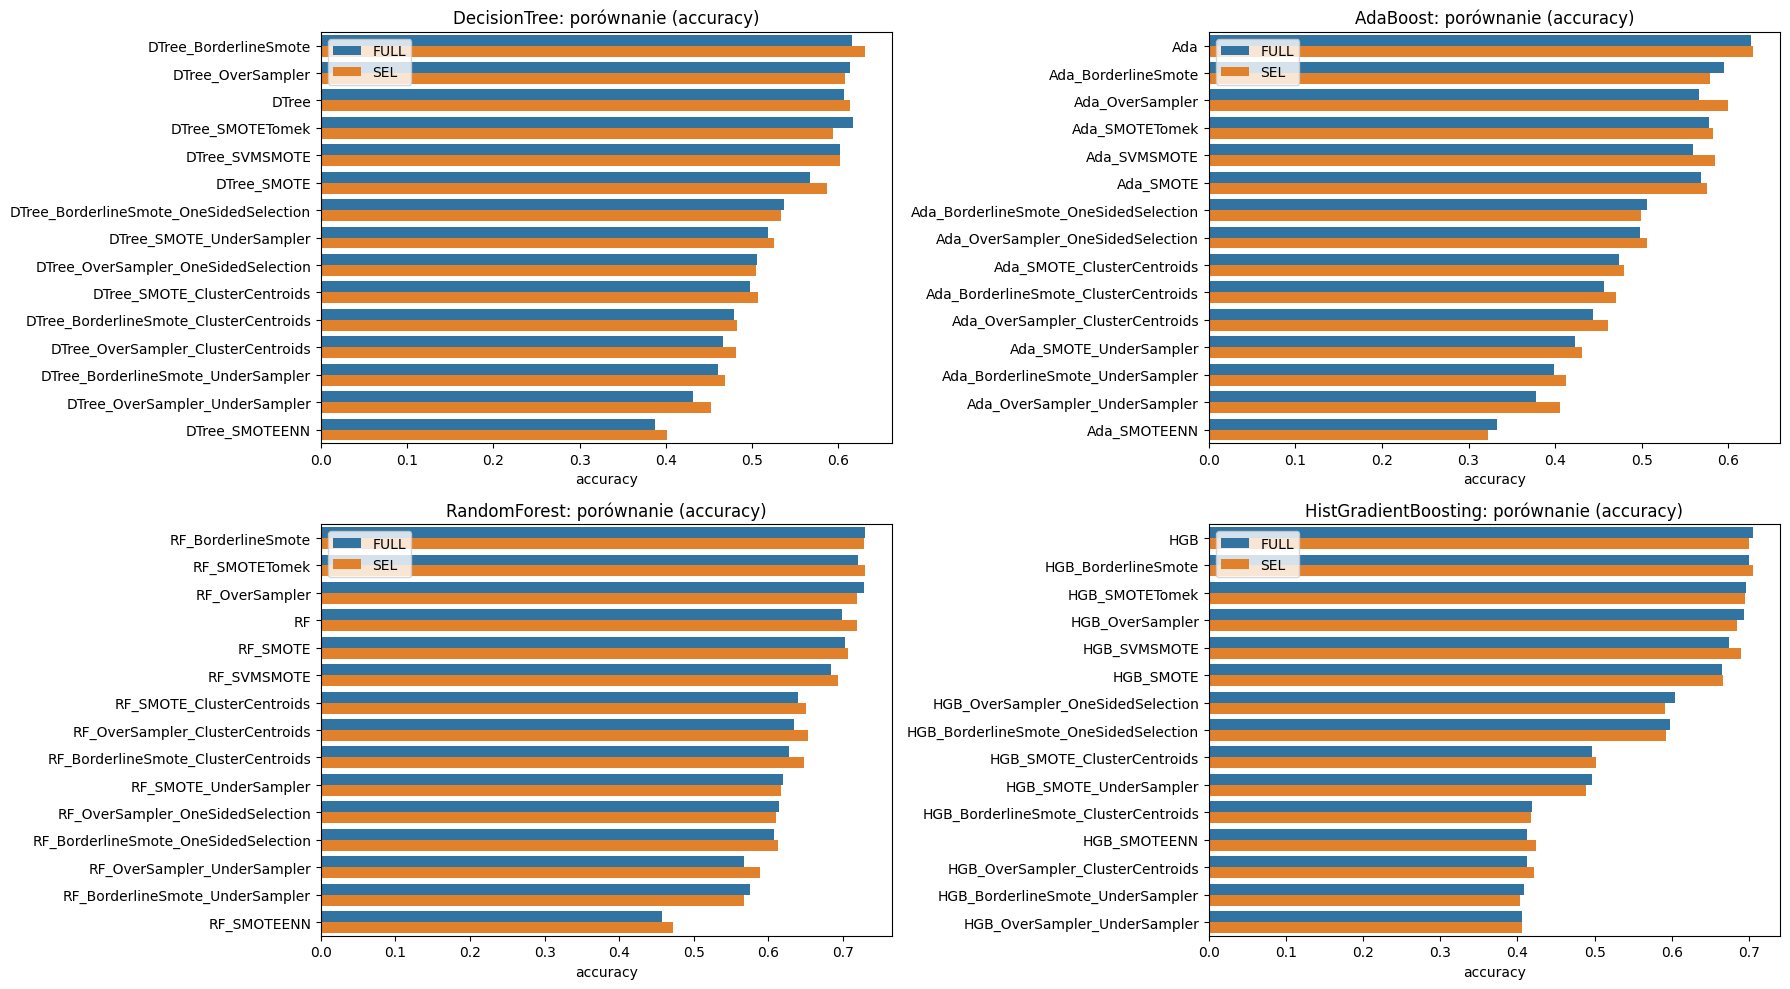

In [68]:
def model_plots(metric="accuracy"):
    create_plots(metric, base_models, (2, 2), (18, 10), "")
model_plots(metric=metrics[0])

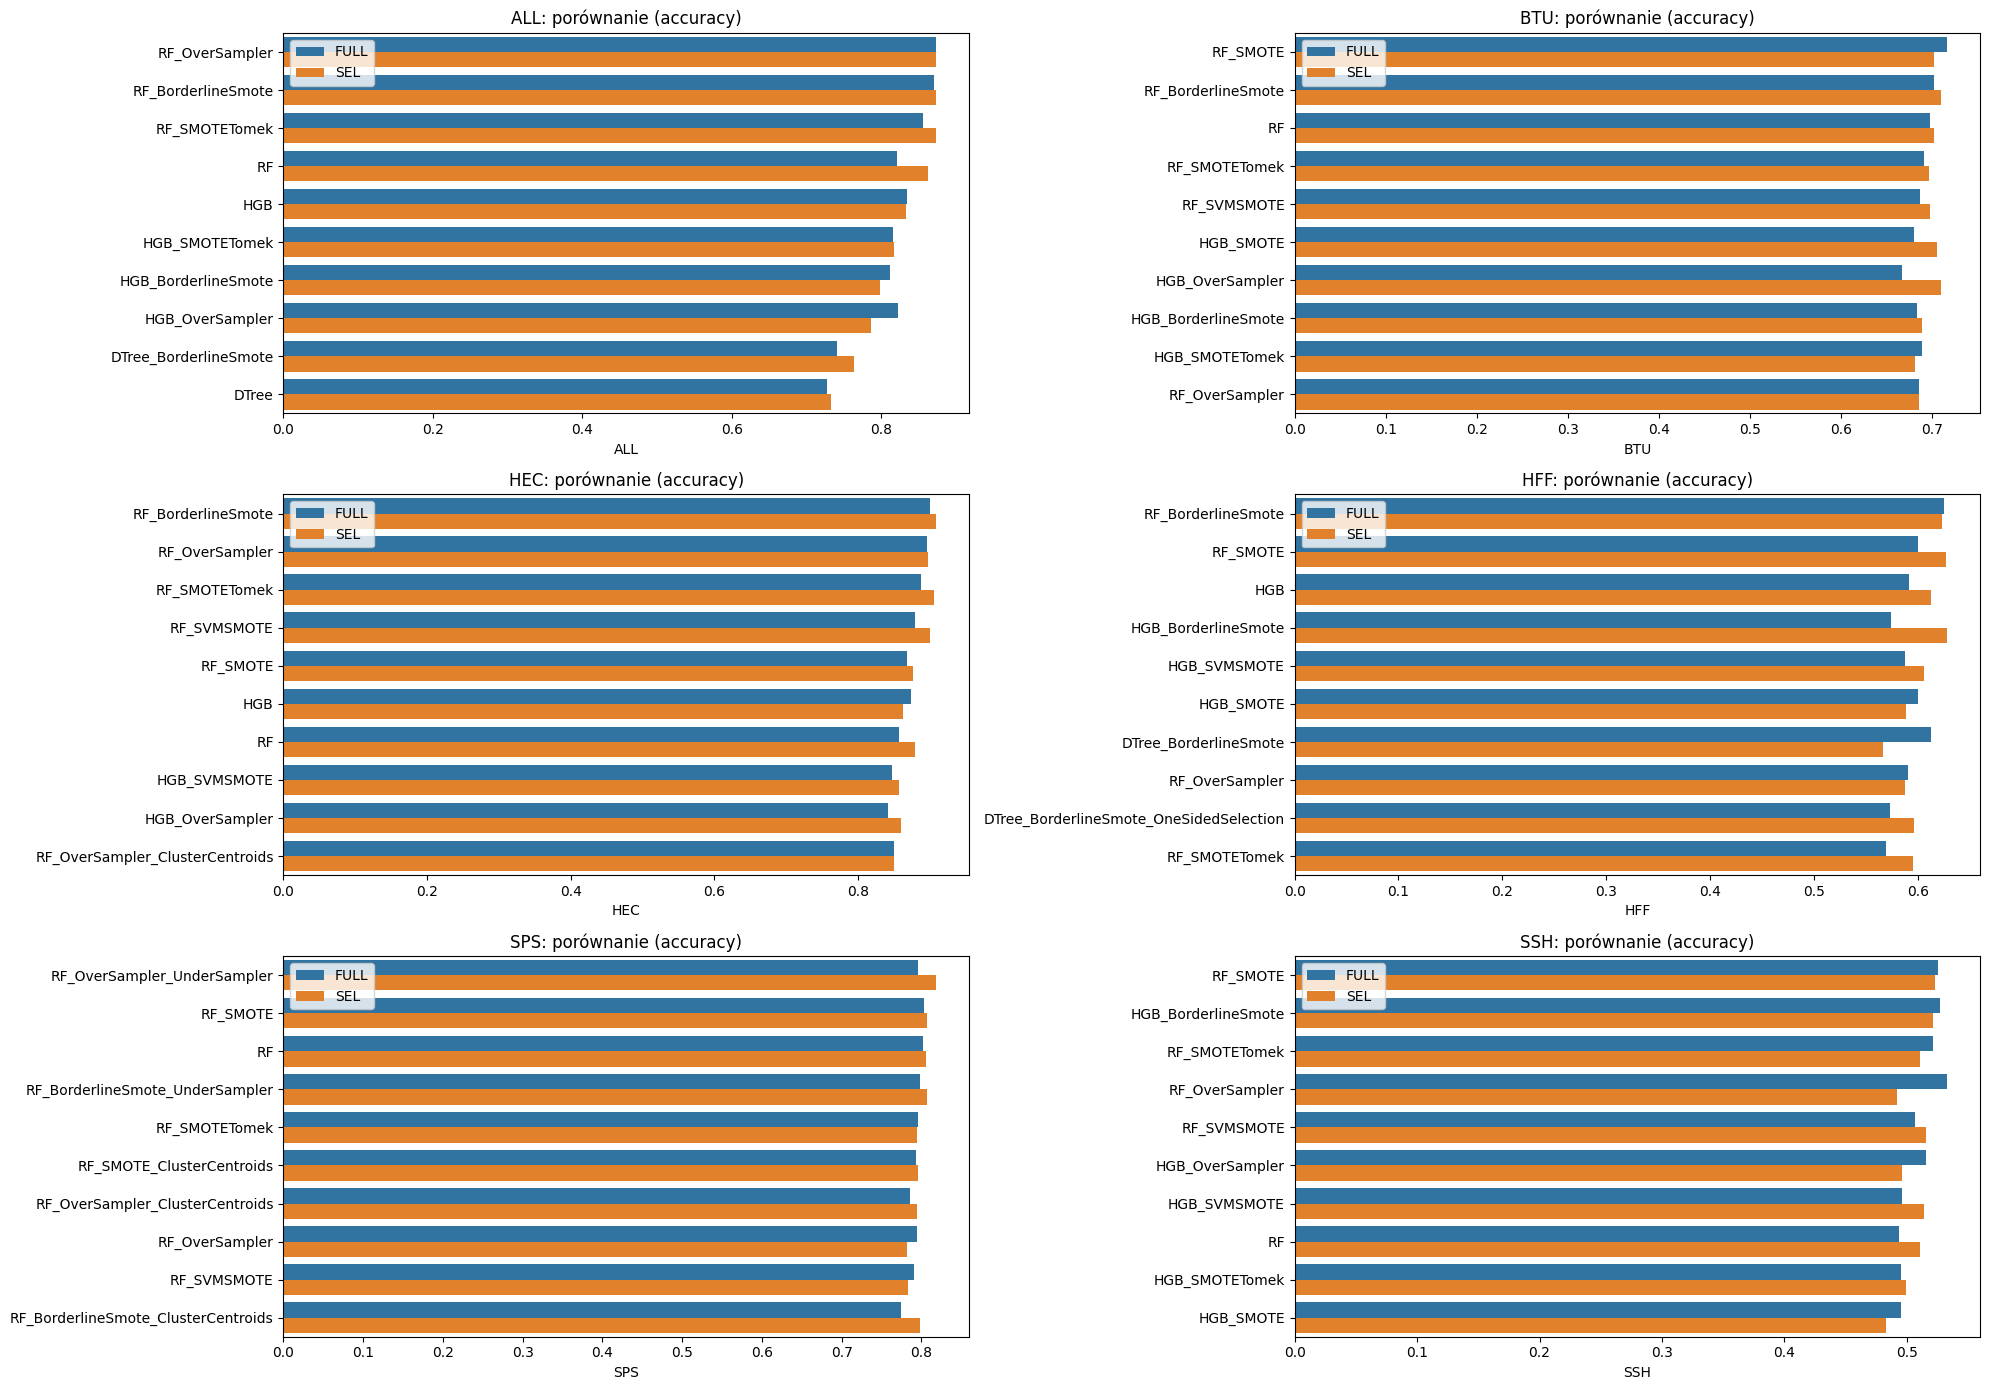

In [69]:
def dataset_plots(metric="accuracy"):
    create_plots(metric, datasets, (3, 2), (20, 14), "")
dataset_plots(metric=metrics[0])

zapisywanie tabelki najlepszych kombinacji modeli dla modelu.

In [70]:
def save_excel(filename, group_by_field, sort_metric):
    writer = pd.ExcelWriter(filename, engine='openpyxl')
    
    groups = df["model"].apply(base_model).unique() if group_by_field == "model" else datasets
    
    for group in groups:
        if group_by_field == "model":
            subset = df[df["model"].str.startswith(group)]
            rows = []
            for _, row in subset.iterrows():
                model_name = row["model"]
                for ds in datasets:
                    rows.append({
                        "model": model_name.replace(group, "").strip("_") or model_name,
                        "kategoria": detect_category(model_name),
                        "cechy": row["source"],
                        "Zbiór": ds,
                        **{m: row[f"{ds}_{m}"] for m in metrics}
                    })
        else:
            metric_cols = {m: f"{group}_{m}" for m in metrics}
            rows = [{
                "model": row["model"],
                "base_model": base_model(row["model"]),
                "kategoria": detect_category(row["model"]),
                "cechy": row["source"],
                **{m: row.get(metric_cols[m], pd.NA) for m in metrics}
            } for _, row in df.iterrows()]
        
        out = pd.DataFrame(rows)
        cat_order = ["Czysty", "Oversampling", "Undersampling", "Over+Under", "Hybrid"]
        out["cat_order"] = out["kategoria"].map({c: i for i, c in enumerate(cat_order)})
        # oddzielone cechy
        out = out.sort_values(by=["cechy", sort_metric, "cat_order", "model"], ascending=[True, False, True, True]).drop(columns=["cat_order"])
        # zbite
        # out = out.sort_values(by=[sortMetric, "cat_order", "model"], ascending=[False, True, True])
        
        out.to_excel(writer, sheet_name=group, index=False, startrow=1)
        
        ws = writer.sheets[group]
        ws.insert_rows(1)
        ws.merge_cells(start_row=1, start_column=1, end_row=1, end_column=out.shape[1])
        ws.cell(row=1, column=1).value = group
        ws.cell(row=1, column=1).alignment = Alignment(horizontal='center')
    
    writer.close()
    print(f"Zapisano plik: {filename}")

In [71]:
save_excel("porownanie_modeli_t.xlsx", "model", metrics[0])

Zapisano plik: porownanie_modeli_t.xlsx


zapisywanie tabelki wszystkich wyników dla każdego zbioru

In [72]:
save_excel("porownanie_zbiorow_t.xlsx", "dataset", metrics[0])

Zapisano plik: porownanie_zbiorow_t.xlsx


# Wnioski 4
- Kombinacje modeli z cechami pełnymi i wybranymi dają dobre wyniki, a w większości przypadków selekcja cech zwykle je polepsza, a czasami minimalnie pogarsza.
- W większości przypadków modele osiągały najlepsze wyniki, kiedy zastosowano jeden oversampler albo pojedyńczą hybrydę, lub kiedy działał sam. Więcej niż jeden element pokazywał gorsze wyniki.
- AdaBoost i HGB potrzebowały najmniej modyfikacji dla dobrych wyników, podczas gdy DecisionTree i RandomForest zwykle osiągały lepsze wyniki z modyfikacjami.
- Na wszystkich zbiorach można zobaczyć nieznaczną poprawę wyników po zastosowaniu selekcji cech, gdzie mają bliskie albo równe wyniki w porównaniu z cechami pełnymi 